In [ ]:
import pandas as pd
import numpy as np
from numpy import loadtxt
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Dropout,MaxPooling2D,Conv2D,Flatten,Input,Conv2DTranspose,UpSampling2D,add
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import pickle
from PIL import Image
from tensorflow.keras.models import load_model
from keras.preprocessing.image import img_to_array

In [ ]:
  dir='/content/drive/MyDrive/Data'

In [ ]:
high_res_images = []
low_res_images = []
SIZE=160
for dirname, _, filenames in os.walk(dir):
      for filename in filenames:
        print(os.path.join(dirname, filename))
        img = cv2.imread(os.path.join(dirname, filename))
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_res_images.append(img_to_array(img))
        
for dirname, _, filenames in os.walk(dir):      
      for filename in filenames:        
        print(os.path.join(dirname, filename))
        img = cv2.imread(os.path.join(dirname, filename))
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_res_images.append(img_to_array(img))

In [ ]:
train_high_image = high_res_images[:90]
train_low_image = low_res_images[:90]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

test_high_image = high_res_images[90:]
test_low_image = low_res_images[90:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

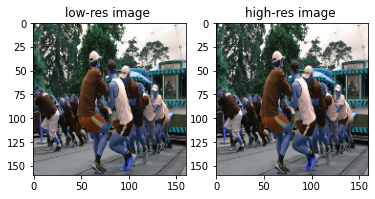

<Figure size 720x720 with 0 Axes>

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.figure(figsize=(10,10))
ax1.imshow(train_high_image[24])
ax1.title.set_text("low-res image ")
ax2.imshow(train_high_image[24])
ax2.title.set_text("high-res image ")

In [ ]:
from tensorflow.python.keras.layers import Input, Dense
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(tf.keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(tf.keras.layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 80, 80, 128)  3584        input_7[0][0]                    
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 40, 40, 128)  147584      sequential_8[0][0]               
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 20, 20, 256)  296192      sequential_9[0][0]               
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [ ]:
model.fit(train_low_image, train_high_image, 
          epochs = 25,
          batch_size = 32,
          verbose = 1,
          shuffle = True)

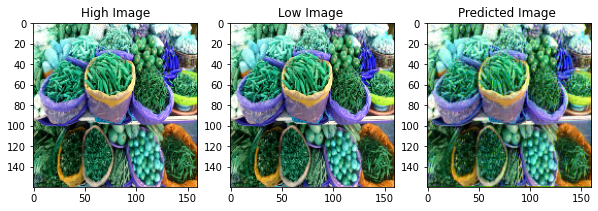

<Figure size 432x288 with 0 Axes>

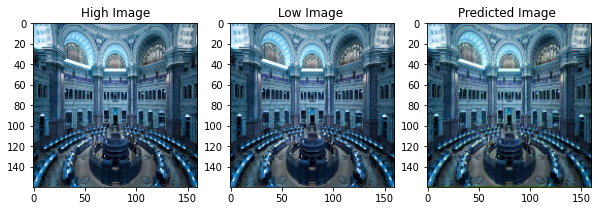

<Figure size 432x288 with 0 Axes>

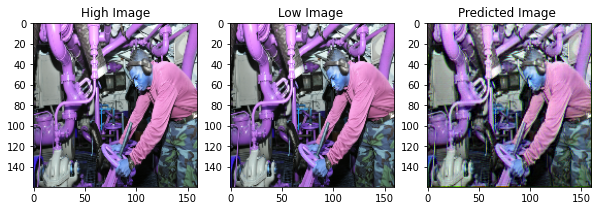

<Figure size 432x288 with 0 Axes>

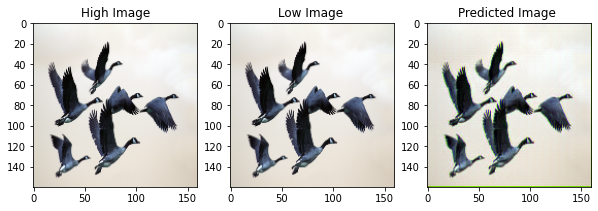

<Figure size 432x288 with 0 Axes>

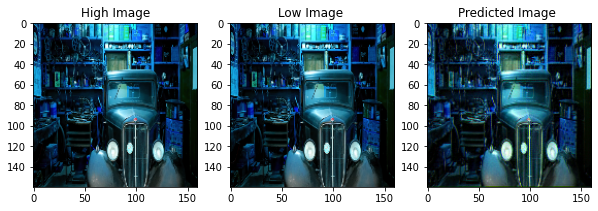

<Figure size 432x288 with 0 Axes>

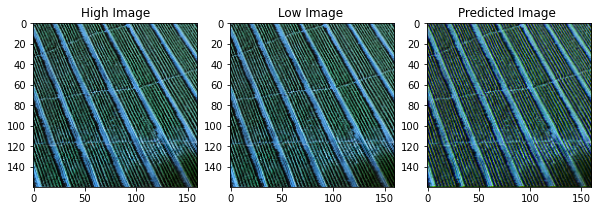

<Figure size 432x288 with 0 Axes>

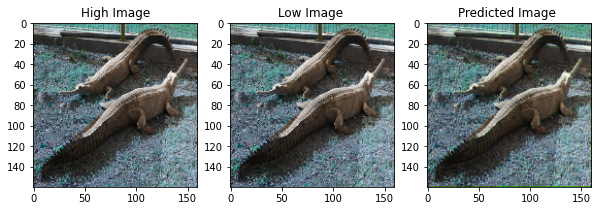

<Figure size 432x288 with 0 Axes>

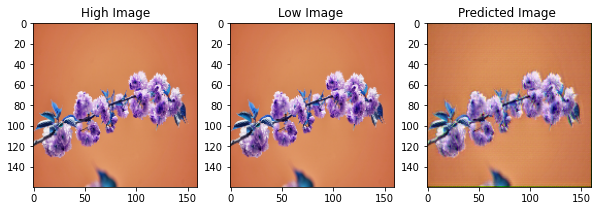

<Figure size 432x288 with 0 Axes>

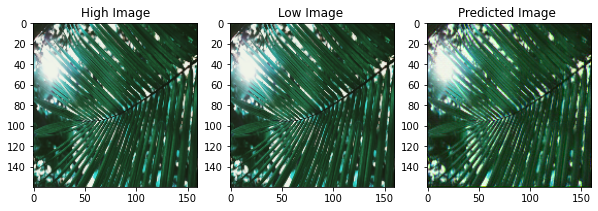

<Figure size 432x288 with 0 Axes>

In [ ]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title('High Image')
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ')
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ')
    plt.imshow(predicted)
    plt.savefig('OUTPUT')
    plt.show()

for i in range(1,10):
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)
    plt.savefig('OUTPUT')